In [20]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp

plt.style.use("seaborn-v0_8-whitegrid") 
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 2,
})

### Gillespie's Algorithm

In [38]:
import numpy as np
from scipy.integrate import solve_ivp

def sir_rhs(t, y, beta, gamma, N):
    """
    Frequency-dependent SIR with COUNTS (X,Y,Z) and fixed population N.
    dX/dt = -beta * X * Y / N
    dY/dt =  beta * X * Y / N - gamma * Y
    dZ/dt =  gamma * Y
    """
    X, Y, Z = y

    # Basic guards to prevent accidental mixing with proportions
    if N <= 0:
        raise ValueError("N must be positive for counts model.")

    inf = beta * X * Y / N
    return [-inf, inf - gamma * Y, gamma * Y]


def integrate_sir(beta, gamma, N, X0, Y0, Z0,
                         t_span=(0.0, 160.0), num_points=1000, method="RK45"):
    """
    Minimal integrator wrapper for counts-based frequency-dependent SIR.
    Returns dict with t, X, Y, Z (arrays).
    """
    
    # Input validation
    
    if any(v < 0 for v in (X0, Y0, Z0)):
        raise ValueError("Initial conditions must be nonnegative counts.")
    if abs((X0 + Y0 + Z0) - N) > 1e-8:
        raise ValueError(f"Initial counts must sum to N. Got X0+Y0+Z0={X0+Y0+Z0}, N={N}.")

    y0 = [float(X0), float(Y0), float(Z0)]
    t_eval = np.linspace(t_span[0], t_span[1], num_points)

    sol = solve_ivp(
        lambda t, y: sir_rhs(t, y, beta, gamma, N),
        t_span, y0, t_eval=t_eval, method=method,
        rtol=1e-8, atol=1e-10
    )

    # Numerical safety: clip tiny negatives from solver noise
    
    Y = np.clip(sol.y, 0.0, None)
    return {"t": sol.t, "X": Y[0], "Y": Y[1], "Z": Y[2]}


def gillespie_sir(beta, gamma, N, X0, Y0, Z0, tmax, rng=None):
    """
    Gillespie's Direct Algorithm for frequency-dependent SIR with COUNTS.
    Propensities:
      a1 = beta * X * Y / N  (infection)
      a2 = gamma * Y         (recovery)
    State updates:
      infection: X-=1, Y+=1
      recovery : Y-=1, Z+=1
    """
    if rng is None:
        rng = np.random.default_rng()

    # Validate & coerce to ints
    
    X, Y, Z = int(X0), int(Y0), int(Z0)
    if X < 0 or Y < 0 or Z < 0:
        raise ValueError("Initial counts must be nonnegative.")
    if X + Y + Z != int(N):
        raise ValueError(f"Initial counts must sum to N. Got {X+Y+Z} vs N={N}.")

    t = 0.0
    times = [0.0]
    X_hist = [X]
    Y_hist = [Y]
    Z_hist = [Z]

    while t < tmax and Y > 0:
        a1 = beta * X * Y / N   # infection
        a2 = gamma * Y          # recovery
        a0 = a1 + a2
        if a0 <= 0.0:
            break

        # exponential waiting time
        t += -np.log(rng.random()) / a0

        # choose reaction
        if rng.random() * a0 <= a1:
            # infection event
            if X > 0:
                X -= 1
                Y += 1
        else:
            # recovery event
            if Y > 0:
                Y -= 1
                Z += 1

        times.append(t)
        X_hist.append(X)
        Y_hist.append(Y)
        Z_hist.append(Z)

    return np.array(times), np.array(X_hist), np.array(Y_hist), np.array(Z_hist)


In [39]:
def resample_step(times, values, t_grid):
    """Piecewise-constant resampling of an event-driven trajectory."""
    
    out = np.empty_like(t_grid, dtype=float)
    j = 0
    curr = values[0]
    for k, tk in enumerate(t_grid):
        while j + 1 < len(times) and times[j + 1] <= tk:
            j += 1
            curr = values[j]
        out[k] = curr
    return out

In [40]:
# Compare stochastic and deterministic SIR models

beta = 0.5
gamma = 0.1
N = 5000
I0 = 5
S0 = N - I0
R0 = 0

t_span = (0.0, 160.0)
num_points = 1000
t_grid = np.linspace(t_span[0], t_span[1], num_points)

# Deterministic solution
det = integrate_sir(beta, gamma, N, S0, I0, R0,
                        t_span=t_span, num_points=num_points)

# Stochastic replicates
n_runs = 200
I_paths = np.zeros((n_runs, num_points), dtype=float)

for r in range(n_runs):
    rng = np.random.default_rng(12345 + r)  # reproducible variety
    times, S_hist, I_hist, R_hist = gillespie_sir(
        beta, gamma, N, S0, I0, R0, tmax=t_span[1], rng=rng
    )
    I_paths[r, :] = resample_step(times, I_hist, t_grid)

I_mean = I_paths.mean(axis=0)

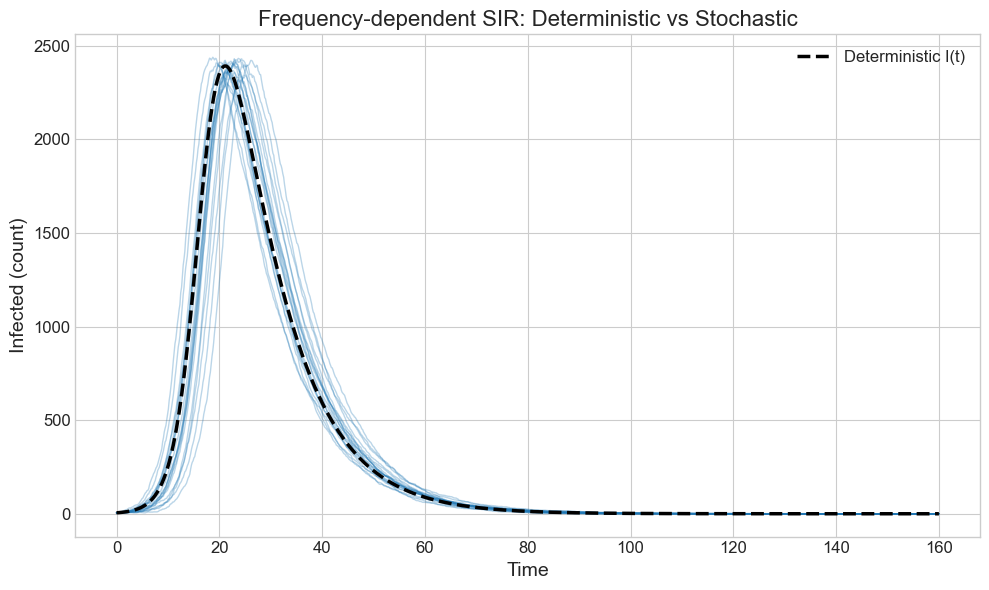

In [41]:
n_show = 20

fig, ax = plt.subplots()

# Stochastic runs
for r in range(n_show):
    ax.plot(t_grid, I_paths[r, :], color="tab:blue", alpha=0.3, lw=1)

# Deterministic
ax.plot(det["t"], det["I"], "k--", lw=2.5, label="Deterministic I(t)")

# Labels and legend
ax.set_xlabel("Time")
ax.set_ylabel("Infected (count)")
ax.set_title("Frequency-dependent SIR: Deterministic vs Stochastic")
ax.legend()

plt.tight_layout()
plt.show()

### Simulation Variability and Negative Co-variance

In [47]:
def run_ensemble(beta, gamma, N, X0, Y0, Z0,
                 t_span=(0.0, 160.0), num_points=1000,
                 n_runs=200, seed0=12345):
    """
    Runs many Gillespie simulations and the deterministic ODE
    using counts (X,Y,Z). Returns t grid, deterministic curves,
    and stacked X/Y/Z paths.
    """
    # Use the counts-based integrator so keys are X,Y,Z
    det = integrate_sir(beta, gamma, N, X0, Y0, Z0,
                               t_span=t_span, num_points=num_points)
    t_grid = det["t"]

    X_paths = np.zeros((n_runs, num_points))
    Y_paths = np.zeros((n_runs, num_points))
    Z_paths = np.zeros((n_runs, num_points))

    for r in range(n_runs):
        rng = np.random.default_rng(seed0 + r)
        times, X_hist, Y_hist, Z_hist = gillespie_sir(
            beta, gamma, N, X0, Y0, Z0, tmax=t_span[1], rng=rng
        )
        X_paths[r, :] = resample_step(times, X_hist, t_grid)
        Y_paths[r, :] = resample_step(times, Y_hist, t_grid)
        Z_paths[r, :] = resample_step(times, Z_hist, t_grid)

    return t_grid, det, X_paths, Y_paths, Z_paths


In [48]:
def ensemble_stats(X_paths, Y_paths, Z_paths):
    """Compute time-wise mean/variance for X, Y, Z, and Cov[X,Y] (counts)."""
    X_mean = X_paths.mean(axis=0)
    Y_mean = Y_paths.mean(axis=0)
    Z_mean = Z_paths.mean(axis=0)

    X_var  = X_paths.var(axis=0, ddof=1)
    Y_var  = Y_paths.var(axis=0, ddof=1)
    Z_var  = Z_paths.var(axis=0, ddof=1)

    XY_mean = (X_paths * Y_paths).mean(axis=0)
    XY_cov  = XY_mean - X_mean * Y_mean

    return {
        "X_mean": X_mean, "Y_mean": Y_mean, "Z_mean": Z_mean,
        "X_var": X_var,   "Y_var": Y_var,   "Z_var": Z_var,
        "XY_cov": XY_cov
    }

In [ ]:
from math import ceil

beta = 0.5
gamma = 0.1
t_span = (0, 160)
num_points = 1000
n_runs = 200

N_list = [500, 1000, 2000, 5000, 10000]
I0_fixed = 5
i0_frac = I0_fixed / 5000

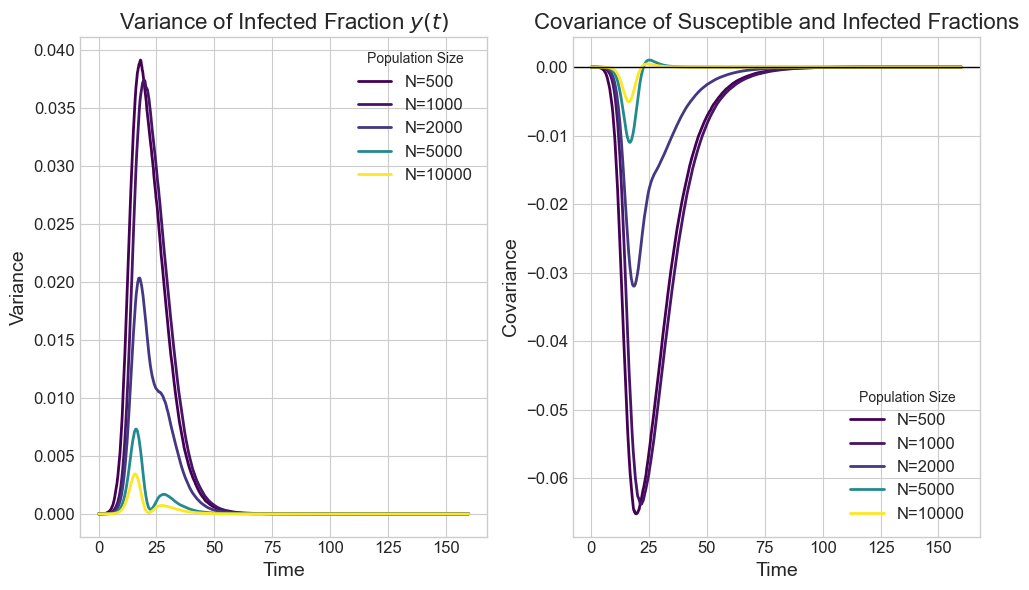

In [57]:
fig, (ax_var, ax_cov) = plt.subplots(1, 2)

Nmin, Nmax = min(N_list), max(N_list)

for N in N_list:
    # fixed initial fraction
    Y0 = max(1, int(ceil(i0_frac * N)))
    X0, Z0 = N - Y0, 0

    t, det, X_paths, Y_paths, Z_paths = run_ensemble(
        beta, gamma, N, X0, Y0, Z0,
        t_span=t_span, num_points=num_points, n_runs=n_runs, seed0=6000
    )

    # convert to fractions
    y_paths = Y_paths / N
    x_paths = X_paths / N

    # normalized stats
    y_var = y_paths.var(axis=0, ddof=1)
    xy_mean = (x_paths * y_paths).mean(axis=0)
    xy_cov = xy_mean - x_paths.mean(axis=0) * y_paths.mean(axis=0)

    color = plt.cm.viridis((N - Nmin) / (Nmax - Nmin))

    # Variance of infected fraction
    ax_var.plot(t, y_var, color=color, label=f"N={N}")
    
    # Covariance of susceptible vs infected fractions
    ax_cov.plot(t, xy_cov, color=color, label=f"N={N}")

ax_cov.axhline(0, color="k", lw=1)

ax_var.set_title("Variance of Infected Fraction $y(t)$")
ax_var.set_xlabel("Time"); ax_var.set_ylabel("Variance")

ax_cov.set_title("Covariance of Susceptible and Infected Fractions")
ax_cov.set_xlabel("Time"); ax_cov.set_ylabel("Covariance")

ax_var.legend(title="Population Size")
ax_cov.legend(title="Population Size")

plt.tight_layout()
plt.show()